In [1]:
# import modules
import joblib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# set paths
DATAPATH = "./data"
DATAPROCESSEDPATH = "./data_preprocessed"
MODELPATH = "./models"

In [3]:
# load training dataset
with open(DATAPROCESSEDPATH + '/data_preprocessed.pkl','rb') as f:
    df = joblib.load(f)

df.head()    

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,business_or_commercial,loan_amount,Neg_ammortization,interest_only,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,Region,Status
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nob/c,116500,not_neg,not_int,1740.0,EXP,758,CIB,25-34,to_inst,south,1
1,24891,2019,cf,Male,nopre,type2,p1,l1,b/c,206500,not_neg,not_int,4980.0,EQUI,552,EXP,55-64,to_inst,North,1
2,24892,2019,cf,Male,pre,type1,p1,l1,nob/c,406500,neg_amm,not_int,9480.0,EXP,834,CIB,35-44,to_inst,south,0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nob/c,456500,not_neg,not_int,11880.0,EXP,587,CIB,45-54,not_inst,North,0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nob/c,296500,not_neg,not_int,10440.0,CRIF,602,EXP,25-34,not_inst,North,0


In [4]:
# seperate into numerical and categorical features
num_features = list(df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index[2:-1])
cat_features = list(df.dtypes[df.dtypes == 'object'].index)
label = ['Status']
print('-----------------------------------')
print('numeric features: \n', num_features)
print('-----------------------------------')
print('categorical features: \n', cat_features)

-----------------------------------
numeric features: 
 ['loan_amount', 'income', 'Credit_Score']
-----------------------------------
categorical features: 
 ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region']


In [5]:
# Separate into train and test sets
X = df[num_features + cat_features]
y = df[label].values.reshape(-1)
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(X, y, df, test_size=0.3, stratify=y, random_state=123)

# Make Pipeline

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay


from lightgbm import LGBMClassifier



In [7]:
# choose classifier
classifier = LGBMClassifier(random_state=123)

In [8]:
# Define preprocessing for numeric columns (normalize them so they're on the same scale)
numeric_features = list(np.arange(0,3)) # note that numbers are required here, not names!

# Define preprocessing for categorical features (e.g. encode the Age column)
categorical_features = list(np.arange(3,17))

In [9]:
# setup the pipeline elements
numeric_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                                    ('scaler', MinMaxScaler())
                                     ]
                               )
                               
categorical_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                    ('onehotencode', OneHotEncoder(handle_unknown='error', drop='first', sparse=True))
                                          ]
                                    )

In [10]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[
                                               ('num', numeric_transformer, numeric_features), 
                                               ('cat', categorical_transformer, categorical_features)
                                              ], remainder='drop'
                                 )

In [11]:
# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[
                           ('preprocessor', preprocessor),
                           ('gbc', classifier)
                          ]
                    )

In [12]:
# fit the pipeline 
pipe = pipeline.fit(X_train, y_train)
print (pipe)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencode',
                                                                   OneHotEncoder(drop='first'))]),
                                                  [3, 4, 5, 6, 7, 8, 9, 10, 11,

Confusion Matrix:
 [[33399   210]
 [ 5649  5343]] 

Accuracy: 0.8686352323938925
Overall Precision: 0.9621826039978391
Overall Recall: 0.48608078602620086
AUC: 0.8421675722127352


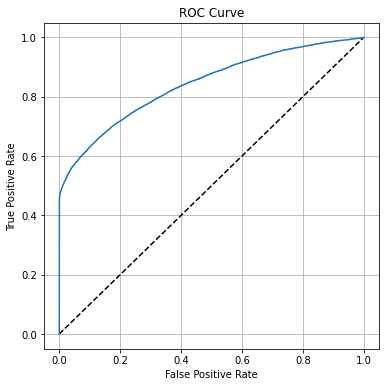

In [13]:
# Get predictions from test data
predictions = pipe.predict(X_test)
y_scores = pipe.predict_proba(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test, predictions))
print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid('on')
plt.show()

In [14]:
# Save the pipeline as a pickle file
filename = '/pipeline.pkl'
joblib.dump(pipe, MODELPATH + filename)

['./models/pipeline.pkl']

# Test Scoring New Data

In [15]:
# load training dataset
with open(DATAPROCESSEDPATH + '/data_preprocessed.pkl','rb') as f:
    df_new = joblib.load(f)

# select first row
df_new = df_new[0:1]
df_new.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,business_or_commercial,loan_amount,Neg_ammortization,interest_only,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,Region,Status
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nob/c,116500,not_neg,not_int,1740.0,EXP,758,CIB,25-34,to_inst,south,1


In [16]:
# load pipeline
with open(MODELPATH + '/pipeline.pkl','rb') as f:
    pipe_loaded = joblib.load(f)

print(pipe_loaded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencode',
                                                                   OneHotEncoder(drop='first'))]),
                                                  [3, 4, 5, 6, 7, 8, 9, 10, 11,

In [17]:
# seperate into numerical and categorical features
num_features = list(df_new.dtypes[(df_new.dtypes == 'int64') | (df_new.dtypes == 'float64')].index[2:-1])
cat_features = list(df_new.dtypes[df_new.dtypes == 'object'].index)
label = ['Status']
print('-----------------------------------')
print('numeric features: \n', num_features)
print('-----------------------------------')
print('categorical features: \n', cat_features)

-----------------------------------
numeric features: 
 ['loan_amount', 'income', 'Credit_Score']
-----------------------------------
categorical features: 
 ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region']


In [18]:
# get feature array
X_new = df_new[num_features + cat_features]
X_new

,loan_amount,income,Credit_Score,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,business_or_commercial,Neg_ammortization,interest_only,credit_type,co-applicant_credit_type,age,submission_of_application,Region
0,116500,1740.0,758,cf,Sex Not Available,nopre,type1,p1,l1,nob/c,not_neg,not_int,EXP,CIB,25-34,to_inst,south


In [19]:
# make prediction
pipe_loaded.predict(X_new)

array([0], dtype=int64)